## FEWS NET Data Warehouse (FDW) Crop Data Preparation
This script accesses and obtains crop production data from [FEWS NET Data Warehouse (FDW)](https://fdw.fews.net/en/).
- Full API document is [here](https://fdw.fews.net/en/docs/users/api.html).
- FEWS NET country administrative boundaries are [here](https://fews.net/fews-data/334).
- [FAO - Food Security and Nutrition Analysis Unit - Somalia](https://fsnau.org/)

By Donghoon Lee @ 09-21-2020

In [2]:
from configparser import ConfigParser
from io import BytesIO, StringIO
import requests
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import json
import seaborn as sns
init_notebook_mode(connected=True)


# Host address
host = 'https://fdw.fews.net'
# Set the credentials as appropriate
parser = ConfigParser(interpolation=None)
parser.read('./data/nb.cfg')
username = parser.get('my_credentials', 'username')
password = parser.get('my_credentials', 'password')
auth = (username, password)

In [3]:
# Crop list
product_list = {'R01142AA': 'Sorghum',                  # KE, SO
                'R01142AA': 'Maize Grain (White)',      # KE
                'R01122AA': 'Maize (Corn)'}             # SO

# Set up the parameters
countries = sorted(['Somalia'])
parameters = {
    'format': 'json',
    'country': countries,
    'survey_type': 'crop:best',
    'product': 'R01122AA'
}

# Get the Crop Production Indicator Values (i.e. the list of Data Points)
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()

# Turn the records into a Pandas DataFrame
df = pd.DataFrame.from_records(response.json())

# Remove unnecessary columns
retain_cols = ['fnid',
               'admin_1','admin_2','admin_3','admin_4',
               'start_date',
               'period_date',
               'season_name',
               'season_type',
               'indicator',
               'value']
df = df[retain_cols]

### Clean out FDW records
This follows procedures done by Frank's ERL paper.

In [4]:
# 1) Only Deyr and Gu, not out of season obs.
df = df[df['season_name'].isin(['Deyr', 'Gu'])]

In [6]:
# Load FEWSNET admin boundaries of Somalia (1990)
adm1_1990 = gpd.read_file('./data/shapefile/SO_Admin1_1990.shp')   # Total 18 FNID
adm2_1990 = gpd.read_file('./data/shapefile/SO_Admin2_1990_revised.shp')   # Total 74 FNID

# Check any data under admin level2
assert df[['admin_3', 'admin_4']].notna().sum().sum() == 0

# Number of unique FNID
df1 = df[df['admin_2'].isna()]   # Total 14 unique FNID
df2 = df[~df['admin_2'].isna()]  # Total 47 unique FNID

# Check whether the FNID are matched between FDW data and FEWSNET maps
# (This quickly checks any changes in administrative boundaries.)
num_fnid_adm1 = np.isin(df1['fnid'].unique(), adm1_1990['FNID'].unique()).sum()
num_fnid_adm2 = np.isin(df2['fnid'].unique(), adm2_1990['FNID'].unique()).sum()
print('Unique administrative units (FNID)')
print('Admin1: %d/%d (data/map) (%d are identical)' % (df1['fnid'].nunique(), adm1_1990['FNID'].nunique(), num_fnid_adm1))
print('Admin2: %d/%d (data/map) (%d are identical)' % (df2['fnid'].nunique(), adm2_1990['FNID'].nunique(), num_fnid_adm2))

# Second dropping columns
df1 = df1.drop(['admin_1','admin_2','admin_3','admin_4'], axis=1)
df2 = df2.drop(['admin_1','admin_2','admin_3','admin_4'], axis=1)

# Mismatched FNID
mismatched_adm2 = df2['fnid'].unique()[~np.isin(df2['fnid'].unique(), adm2_1990['FNID'].unique())]
print('\nThe mismatched FNID in admin_2 level: %s' % mismatched_adm2)

# Correction
# FNID SO1990R22805 (Afmadow) and SO1990R22806 (Hagar) are seperated regions of SO1990A22802 (Afmadow). 
# This is confirmed by FEWS NET crop reporting unit (./data/admin_boundaries/SO_Crop_Units_1990.shp)
# Since SO1990A22802 has only one time record, we aggregate SO1990R22805 and SO1990R22806 to represent productions in SO1990A22802.


Unique administrative units (FNID)
Admin1: 9/18 (data/map) (9 are identical)
Admin2: 41/74 (data/map) (39 are identical)

The mismatched FNID in admin_2 level: ['SO1990R22805' 'SO1990R22806']


### Convert to time-series data

In [7]:
# Multi-index
prod1 = [df1['fnid'].unique(), ['Area Harvested','Area Planted','Quantity Produced','Yield']]
mindex1 = pd.MultiIndex.from_product(prod1, names=['fnid', 'indicator'])
prod2 = [df2['fnid'].unique(), ['Area Harvested','Area Planted','Quantity Produced','Yield']]
mindex2 = pd.MultiIndex.from_product(prod2, names=['fnid', 'indicator'])
# Pivoted time-series
df1 = pd.pivot_table(df1, values='value', index=['fnid','indicator'],
                     aggfunc= 'sum', columns='period_date').reindex(mindex2).T
df1 = df1.sort_index(axis=1,level=[0,1],ascending=True)
df2 = pd.pivot_table(df2, values='value', index=['fnid','indicator'], 
                     aggfunc= 'sum', columns='period_date').reindex(mindex2).T
df2 = df2.sort_index(axis=1,level=[0,1],ascending=True)
# Quantity Produced
df1_prod = df1.loc(axis=1)[pd.IndexSlice[:, 'Quantity Produced']]
df1_prod.columns = df1_prod.columns.droplevel(level=1)
df2_prod = df2.loc(axis=1)[pd.IndexSlice[:, 'Quantity Produced']]
df2_prod.columns = df2_prod.columns.droplevel(level=1)

In [22]:
df2_prod

fnid,SO1990A21201,SO1990A21203,SO1990A21301,SO1990A21303,SO1990A21304,SO1990A21501,SO1990A22001,SO1990A22002,SO1990A22003,SO1990A22101,...,SO1990A22605,SO1990A22606,SO1990A22701,SO1990A22702,SO1990A22703,SO1990A22801,SO1990A22803,SO1990A22804,SO1990R22805,SO1990R22806
period_date,,,,,,,,,,,,,,,,,,,,,
1983-02-28,NaN,NaN,NaN,NaN,NaN,NaN,600.000000,800.000000,600.000000,3000.000000,...,NaN,0.000000,400.000000,600.000000,400.000000,1200.000000,NaN,4800.000000,NaN,NaN
1983-08-31,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN
1984-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-08-31,NaN,NaN,NaN,NaN,NaN,NaN,800.000000,1600.000000,1600.000000,13100.000000,...,NaN,1000.000000,2900.000000,8600.000000,2000.000000,5000.000000,NaN,14900.000000,NaN,NaN
1985-02-28,NaN,200.000000,NaN,NaN,NaN,NaN,7000.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-08-31,NaN,1851.300000,NaN,NaN,NaN,NaN,200.000000,1500.000000,3000.000000,17280.000000,...,NaN,7440.000000,2200.000000,6290.000000,2200.000000,7280.000000,NaN,4320.000000,NaN,NaN
1986-02-28,NaN,14148.000000,NaN,NaN,NaN,NaN,NaN,160.000000,400.000000,6600.000000,...,80.000000,640.000000,80.000000,160.000000,80.000000,300.000000,NaN,3300.000000,NaN,NaN
1986-08-31,NaN,14148.000000,NaN,NaN,NaN,NaN,NaN,950.000000,2750.000000,27000.000000,...,2900.000000,3050.000000,2700.000000,11600.000000,6700.000000,1500.000000,NaN,12400.000000,NaN,NaN
1987-02-28,NaN,NaN,NaN,400.0000,NaN,630.0,NaN,NaN,220.000000,5800.000000,...,300.000000,750.000000,70.000000,0.000000,300.000000,NaN,NaN,250.000000,NaN,NaN


### Compare Adm1 and Adm2 data
- How does admin2 data explain admin1? What are their relationships?

In [59]:
temp = df2_prod.copy()
temp.index = pd.to_datetime(temp.index).strftime('%y')

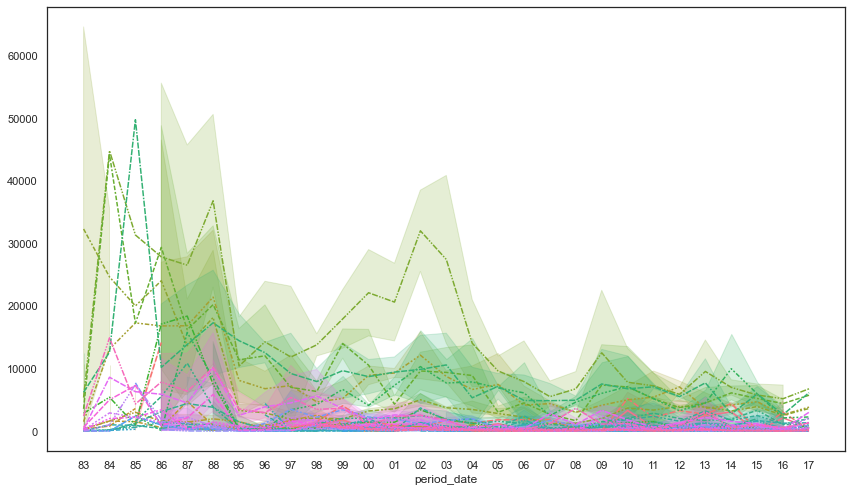

In [60]:
# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7), facecolor='w')

ax = sns.lineplot(data=temp,legend=False)
plt.tight_layout()
plt.show()